In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Hiper-parámetros

* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

**xgboost en python**

import xgboost as xgb

**read in data**

dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

**specify parameters via map**

param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

**make prediction**
preds = bst.predict(dtest)

## Importando DF y observando datos

In [ ]:
DataFrame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos para leer /Tp2/Train_TP2_Datos_2020-2C.csv')

In [ ]:
DataFrame.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


## 

In [ ]:
DataFrame['Delivery_Year'].value_counts()

2017    6318
2018    5830
2016    4371
2019     414
2020      14
Name: Delivery_Year, dtype: int64

In [ ]:
DataFrame[['Delivery_Year', 'Delivery_Quarter']][DataFrame['Delivery_Year'] == 2018]['Delivery_Quarter'].value_counts()

Q2    1582
Q4    1435
Q1    1431
Q3    1382
Name: Delivery_Quarter, dtype: int64

## **Conversion a dolar y promedio de valores**

(Fijarse si aplicar  conversion de log a los valores porque hay muchos altos y muchos bajos, hay gran dif) y (esto hay que hacerlo dsp de filtrar porque estamos usando datos que a lo mejor ni nos pintan )

In [ ]:
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame['Total_Amount']*0.0096
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame['Total_Amount']*1.17
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame['Total_Amount']*0.70
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame['Total_Amount']*1.29
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [ ]:
DataFrame['Total_Amount'].value_counts()

5.952000e+01    513
4.224000e+01    460
1.728000e+02    351
1.344000e+03    272
1.536000e+01    204
               ... 
1.075200e+04      1
6.869055e+05      1
3.163680e+04      1
1.373772e+06      1
1.749888e+06      1
Name: Total_Amount, Length: 9350, dtype: int64

In [ ]:
DataFrame['Total_Amount'].mean()

1007398.2109417549

## Filtrando por datos que voy a usar

In [ ]:
DataFrame_short = DataFrame[['Region', 'Total_Amount', 'Delivery_Year', 'Delivery_Quarter','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr','Stage' ]].rename(columns={'Stage': 'Decision'})
DataFrame_short = DataFrame_short[(DataFrame_short['Decision'] == 'Closed Lost') | (DataFrame_short['Decision'] == 'Closed Won')]
DataFrame_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
0,EMEA,6169176.0,2016,Q2,1,1,Closed Lost
1,EMEA,56429.1,2016,Q1,0,0,Closed Won
2,Americas,83865.6,2016,Q1,0,0,Closed Won
3,Americas,7421881.5,2018,Q1,0,1,Closed Lost
4,Americas,13357192.5,2018,Q1,0,1,Closed Lost


## Codificación de variables 

**Poner 1 en aquellos que sean >= que 1007398.2109417549 y 0 en aquellos que sean menores que tal monto** (A HACER)


**Hacer en binario los cuarter o va, ponerlos directamente en numero (1 2 3 o 4)**  **hecho, q4 == 1, q1,2,3 = 0**

**Closed lost y won ponerlos en 0 y 1 respectivamente** . **Hecho**

**Hacer en binario las regiones** (A HACER)

In [ ]:
DataFrame_short['Decision'].value_counts()

Closed Won     9533
Closed Lost    7350
Name: Decision, dtype: int64

In [ ]:
DataFrame_short['Decision'] = np.where(DataFrame_short['Decision'] == 'Closed Won',1,0)

In [ ]:
DataFrame_short['Decision'].value_counts()

1    9533
0    7350
Name: Decision, dtype: int64

**Aca flasheo la de Gardel y te clavo 1 en q4 y 0 en los otros**

In [ ]:
DataFrame_short['Delivery_Quarter'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q4',1,0)

In [ ]:
DataFrame_short['Delivery_Quarter'].value_counts()

0    12749
1     4134
Name: Delivery_Quarter, dtype: int64

**Flasheando de nuevo, ahora para simplificar le clavo el promedio a las regiones asi no hago binary encoding y toda esa wea**

In [ ]:
DataFrame_short['Region'].value_counts()

Japan          4869
EMEA           4660
Americas       3933
APAC           3251
Middle East     170
Name: Region, dtype: int64

In [ ]:
DataFrame_short['Region'] = DataFrame_short.groupby('Region')['Region'].transform('count')

In [ ]:
DataFrame_short['Region'].value_counts()

4869    4869
4660    4660
3933    3933
3251    3251
170      170
Name: Region, dtype: int64

In [ ]:
DataFrame_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
0,4660,6169176.0,2016,0,1,1,0
1,4660,56429.1,2016,0,0,0,1
2,3933,83865.6,2016,0,0,0,1
3,3933,7421881.5,2018,0,0,1,0
4,3933,13357192.5,2018,0,0,1,0


## Separación de entrenamiento y Test

In [ ]:
Entrenamiento = DataFrame_short.loc[:,DataFrame_short.columns != 'Decision']

In [ ]:
Entrenamiento

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,4660,6169176.00,2016,0,1,1
1,4660,56429.10,2016,0,0,0
2,3933,83865.60,2016,0,0,0
3,3933,7421881.50,2018,0,0,1
4,3933,13357192.50,2018,0,0,1
...,...,...,...,...,...,...
16942,4660,120919.50,2016,0,1,1
16943,4660,108827.55,2016,0,1,1
16944,4660,120919.50,2016,0,1,1
16945,3933,2346796.88,2016,0,1,1


In [ ]:
#Test = DataFrame_short[(DataFrame_short['Delivery_Year']== 2018) & (DataFrame_short['Delivery_Quarter'] == 1)]
#Test = Test['Decision']
#Test

In [ ]:
Test = DataFrame_short.loc[:,'Decision']


In [ ]:
Entrenamiento.shape, Test.shape, DataFrame_short.shape

((16883, 6), (16883,), (16883, 7))

##Entrenamiento y Test

Para poder entrenar X e Y tengo que tener la misma cant de filas XD

In [ ]:
X_Entrenamiento, X_EntrenamientoTest, Y_TestEntrenamiento, Y_TestTest = train_test_split(Entrenamiento,Test,test_size = 0.2, random_state = 123)

In [ ]:
X_Entrenamiento.shape, X_EntrenamientoTest.shape, Y_TestEntrenamiento.shape, Y_TestTest.shape

((13506, 6), (3377, 6), (13506,), (3377,))

In [ ]:
#Se realiza el entrenamiento del modelo
xg_clas = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_clas.fit(X_Entrenamiento,Y_TestEntrenamiento)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
preds = xg_clas.predict(X_Entrenamiento)

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_TestEntrenamiento, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.640922


In [ ]:
#from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(Y_Test, preds)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

## Importancia de los features
Le paso una wea ya entrenada 

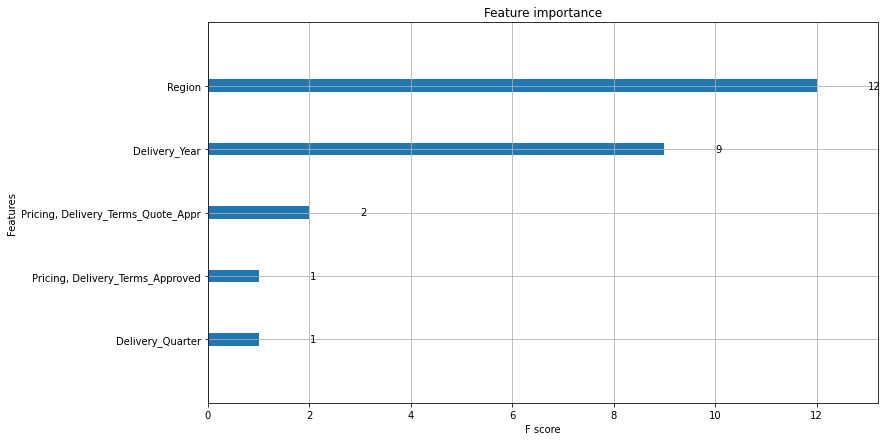

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_clas)